### Author: Harry Ritchie <hritchie8175@gmail.com>
### Application: HR employement data

#### Build a prediction tool from linear regression to predict satisfaction level based on average monthly work hours 
#### and last evaluation. I then built a classification tool on whether or not employees left their jobs based on 
#### last evaluation, average monthly hours and satisfaction level.

 ## 1 REGRESSION 



In [1]:
# Import the data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
# pandas read csv
data = pd.read_csv('/Users/harryritchie/Documents/Personal/Employment/HR_employment/HR_comma_sep.csv',delimiter=';',header=0,engine='python')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### Here we are predicting satisfaction level based on two factors: the last evaluation score, and average monthly hours. 

In [3]:
# Separate response from predictors
y = data['satisfaction_level']
X = data[['last_evaluation', 'average_montly_hours']]

In [4]:
# Split train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=20)

#### Two models are used: linear regression and support vector regression with a gaussian kernel.

In [5]:
# Create linear regression object
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
model_lr = linear_model.LinearRegression()
model_svm = svm.SVR(kernel='rbf')

In [6]:

# Train the model using the training sets
model_lr.fit(X_train, y_train)
model_svm.fit(X_train,y_train)


# Prediction
y_pred_lr = model_lr.predict(X_test)
y_pred_svm = model_svm.predict(X_test)


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


#### The results of each model are based on variance explained and MSE.


In [7]:
# The coefficients LR
print('Coefficients: \n', model_lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lr))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred_lr))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svm))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred_svm))

Coefficients: 
 [ 0.18811062 -0.00035247]
Mean squared error: 0.06
Variance score: 0.01
Mean squared error: 0.05
Variance score: 0.18


### The results


#### We can see that neither of the two models are accurate at predicting satisfaction level. Considering the only features being last evaluation and average monthly hours. This also suggests, based on the SVR, non-linearity in the data. 

 ## 2 Classification


#### Here we now switch over to classification based on whether an employee will leave their job or stay. We utilise four models: Random Trees + Logistic Regression, Random Forests, Random Forests + Logistic Regression, Gradient Boosted Model

In [11]:
# Courtesy of Author: Tim Head <betatim@gmail.com>
np.random.seed(10)
from sklearn.datasets import make_classification
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score


In [13]:
n_estimator = 2
depth = 6
y = data['left']
X = data[['last_evaluation', 'average_montly_hours','satisfaction_level']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train)              

#### We use n_estimators as two, as there are only 3. The standard of random forests is normally the square root of the number of predictors. In this case ~ 2 It is important to train the ensemble of trees on a different subset of the training data than the linear regression model to avoid overfitting, in particular if the total number of leaves is similar to the number of training samples

In [16]:
# Unsupervised transformation based on totally Random Trees + Logistic Regression
rt = RandomTreesEmbedding(max_depth=depth, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_rt_lm = roc_auc_score(y_test, y_pred_rt)

In [17]:
# Supervised transformation based on Random Forests + Logistic Regression 
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm = roc_auc_score(y_test, y_pred_rf_lm)

In [18]:
# Supervised transformation based on Gradient Boosted + Logistic Regression
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm = roc_auc_score(y_test, y_pred_grd_lm)

In [20]:
# The Gradient Boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = roc_auc_score(y_test, y_pred_grd)

In [21]:
# The Random Forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

In [22]:
# Print AUC ROC values
print('\n')
print("AUC VALUES",'\n')
print("N ESTIMATORS = ", n_estimator, "MAX TREE DEPTH = ", depth,'\n')
print("RANDOM TREES AUC = ", auc_rt_lm, '\n')
print("RANDOM FOREST + LINEAR MODEL AUC = ", auc_rf_lm, '\n')
print("GRADIENT BOOSTER + LINEAR MODEL AUC = ", auc_grd_lm, '\n')
print("GRADIENT BOOSTED MODEL AUC = ", auc_grd, '\n')
print("RANDOM FOREST AUC = ", auc_rf, '\n')



AUC VALUES 

N ESTIMATORS =  2 MAX TREE DEPTH =  6 

RANDOM TREES AUC =  0.903704918677 

RANDOM FOREST + LINEAR MODEL AUC =  0.95487212226 

GRADIENT BOOSTER + LINEAR MODEL AUC =  0.925861750609 

GRADIENT BOOSTED MODEL AUC =  0.936160917734 

RANDOM FOREST AUC =  0.954789522275 



In [23]:
# Best AUC
print(max(auc_rt_lm,auc_rf_lm,auc_grd_lm,auc_grd,auc_rf))

0.95487212226


#### Plotting

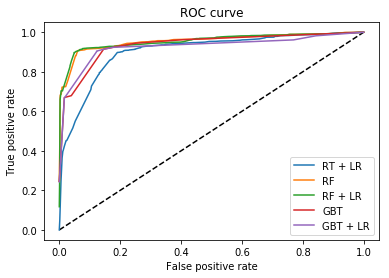

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

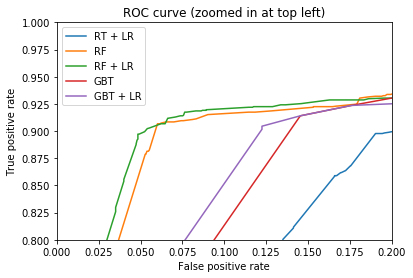

In [25]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()